# Grid Cell Analysis

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import utils
import scipy
import heapq
import math

from place_cells import PlaceCells
from trajectory_generator import TrajectoryGenerator
from model import RNN
from trainer import Trainer

# Instantiate options class
class Options():
    pass
options = Options()

## Network and Analysis Options

In [66]:
# Options for Network to Analyze

options.save_dir = '/home/mira/Grid_Cell_RNN/models'    # directory to save trained models
options.n_epochs = 100      # number of training epochs
options.n_steps = 1000      # number of training steps (batches per epoch)
options.batch_size = 200      # number of trajectories per batch (originally 200)
options.sequence_length = 50  # number of steps per trajectory (originally 20)
options.activation = 'relu'     # activation function chosen (relu or sigmoid)
options.learning_rate = 1e-4  # gradient descent learning rate
options.Np = 512              # number of place cells
options.Ng = 2500             # number of grid cells
options.place_cell_rf = 0.12  # width of place cell center tuning curve (m)
options.surround_scale = 2    # if DoG, ratio of sigma2^2 to sigma1^2
options.weight_decay = 1e-4   # strength of weight decay on recurrent weights
options.DoG = True            # use difference of gaussians tuning curves
options.periodic = False      # trajectories with periodic boundary conditions
options.box_width = 2.2       # width of training environment
options.box_height = 2.2      # height of training environment
options.vel_sigma = 0       # noise in velocity stream
options.vel_scale = 1.0     # attenuation of velocity stream
options.hid_sigma = 0      # noise in hidden stream
options.hid_scale = 1.0        # attenuation of hidden stream
options.replication_num = '01' # ID to differentiate models trained on the same parameters

# Generate run ID
options.run_ID = utils.generate_run_ID(options)

# Put onto GPU if available
options.device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Making place cells
place_cells = PlaceCells(options)

In [67]:
# Analysis Options and Hyperparameters
analysis_options = Options()

analysis_options.batch_size = 20      # number of trajectories per batch
analysis_options.sequence_length = 10000  # number of steps per trajectory
analysis_options.Np = options.Np             # number of place cells
analysis_options.Ng = options.Ng             # number of grid cells
analysis_options.place_cell_rf = 0.12  # width of place cell center tuning curve (m)
analysis_options.surround_scale = 2    # if DoG, ratio of sigma2^2 to sigma1^2
analysis_options.DoG = True            # use difference of gaussians tuning curves
analysis_options.periodic = options.periodic      # trajectories with periodic boundary conditions
analysis_options.box_width = options.box_width       # width of training environment
analysis_options.box_height = options.box_height      # height of training environment

analysis_options.device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [68]:
# Loading trained networks for analysis
net = RNN(options, place_cells).to(options.device)
analysis_trajectory_generator = TrajectoryGenerator(analysis_options, place_cells)

net_train = Trainer(options, net, analysis_trajectory_generator)

Restored trained model from /home/mira/Grid_Cell_RNN/models/steps_50_batch_200_relu_gridcell_2500_rf_012_DoG_True_periodic_False_lr_00001_weight_decay_00001_vsgm_0_vscl_10_hsgm_0_hscl_10_01/most_recent_model.pth


In [6]:
# Adding noise to weights
vel_weight_noise = 0
hid_weight_noise = 0.01

weight_noise_magnitude = hid_weight_noise * torch.std(net.vel_stream.weight)

with torch.no_grad():
    net.vel_stream.weight += vel_weight_noise * torch.randn_like(net.vel_stream.weight)
    net.hid_stream.weight += weight_noise_magnitude * torch.randn_like(net.hid_stream.weight)

In [62]:
# Pruning weights
vel_weight_prune = 0.5
hid_weight_prune = 0

with torch.no_grad():
    net.vel_stream.weight[abs(net.vel_stream.weight) < vel_weight_prune] = 0.0
    net.hid_stream.weight[abs(net.hid_stream.weight) < hid_weight_prune] = 0.0

In [9]:
# Masking
vel_weight_lesion_prob = 0
hid_weight_lesion_prob = 0.001
vel_weight_mask = torch.full_like(net.vel_stream.weight, 1 - vel_weight_lesion_prob)
vel_weight_mask = torch.bernoulli(vel_weight_mask)

hid_weight_mask = torch.full_like(net.hid_stream.weight, 1 - hid_weight_lesion_prob)
hid_weight_mask = torch.bernoulli(hid_weight_mask)

with torch.no_grad():
    net.vel_stream.weight *= vel_weight_mask
    net.hid_stream.weight *= hid_weight_mask

## Testing Network Function
Probing the network's ability to decode position from velocity compared to the actual trajectory and its ability to plot grids

(860, 860, 4)


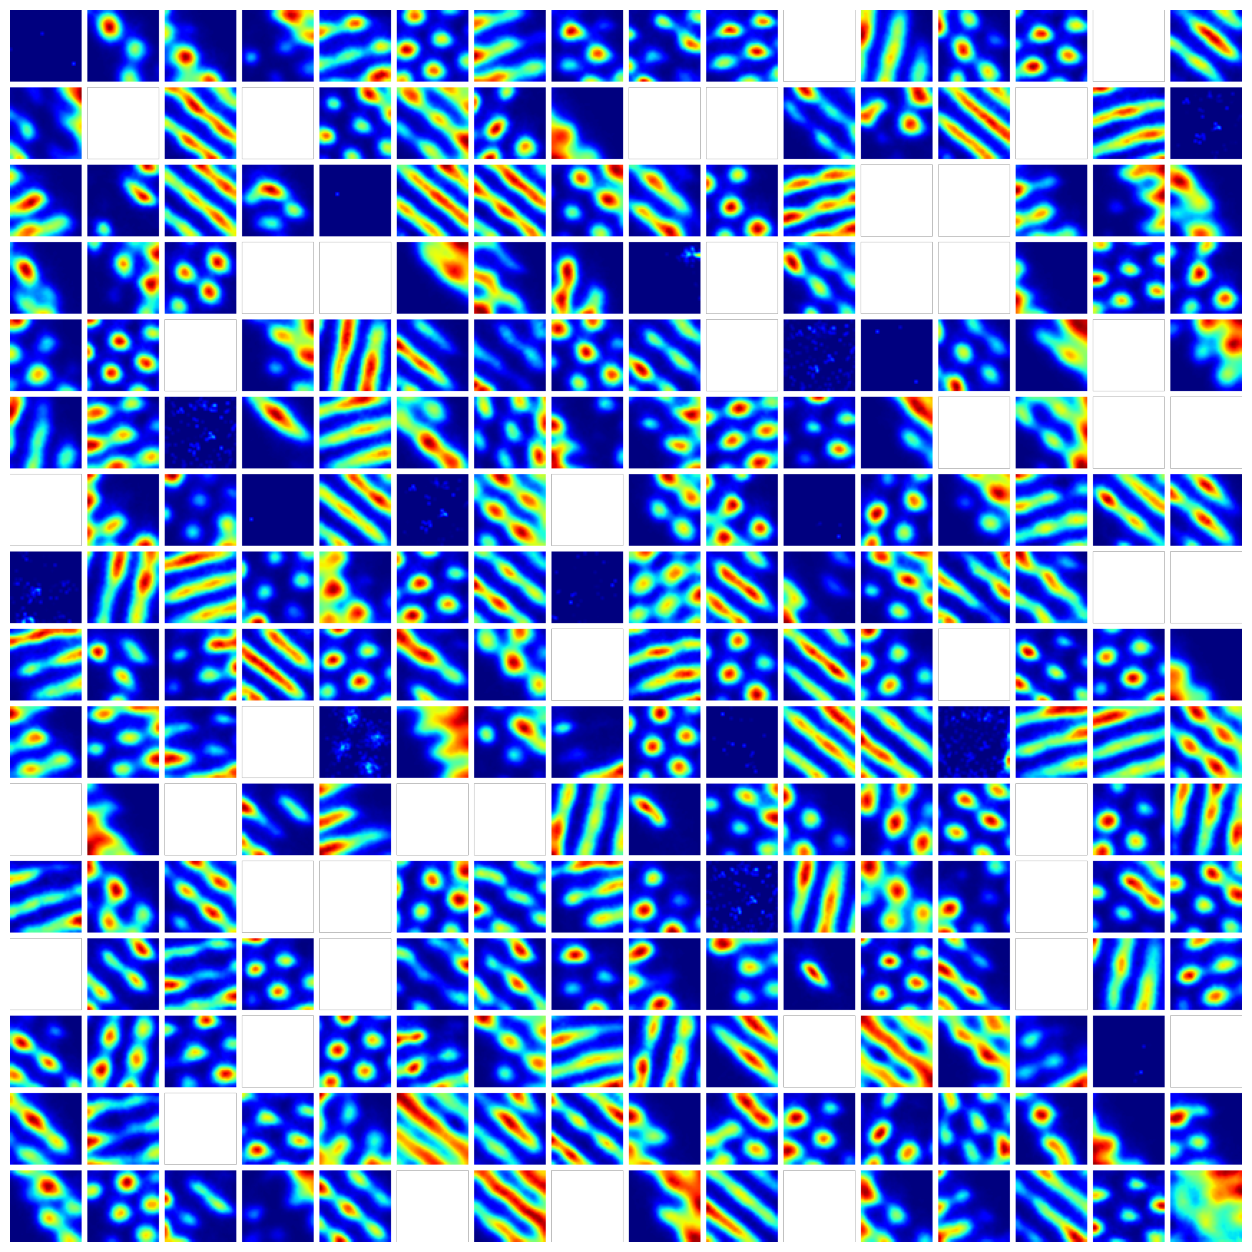

In [24]:
# Plotting grid cells
activations = utils.plot_grid_cells(analysis_options,net,analysis_trajectory_generator,50,10)

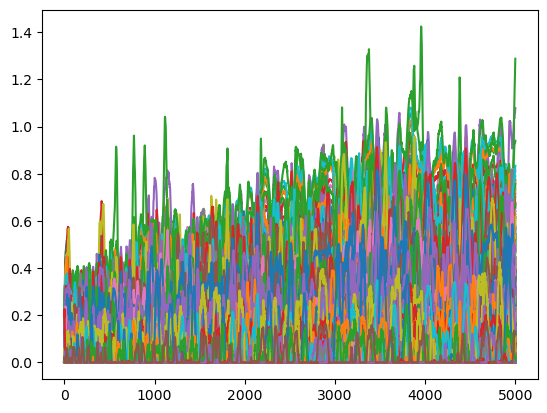

In [92]:
# Plotting neuron activations
neurons = net.neuron_values

plt.plot(neurons);

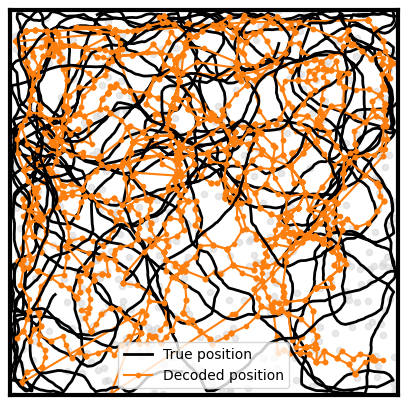

In [78]:
# Plotting the decoded trajectory overlaid with the actual trajectory
inputs, pos, pc_outputs = analysis_trajectory_generator.get_test_batch()
pos = pos.cpu()
pred_pos = place_cells.get_nearest_cell_pos(net.predict(inputs)).cpu()
us = place_cells.us.cpu()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for i in range(5):
    plt.plot(pos[:,i,0], pos[:,i,1], c='black', label='True position', linewidth=2)
    plt.plot(pred_pos[:,i,0], pred_pos[:,i,1], '.-',
             c='C1', label='Decoded position')
    if i==0:
        plt.legend()
plt.scatter(us[:,0], us[:,1], s=20, alpha=0.5, c='lightgrey')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
plt.xticks([])
plt.yticks([])
plt.xlim([-options.box_width/2,options.box_width/2])
plt.ylim([-options.box_height/2,options.box_height/2]);

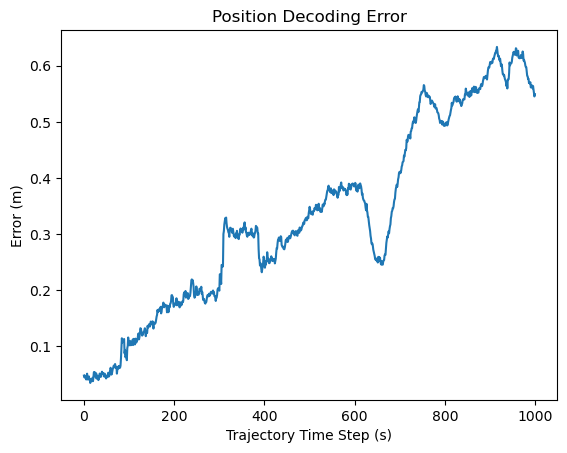

In [79]:
# Plot decoding error in position over time
pos_diff = pred_pos - pos
pos_err_magnitude = np.linalg.norm(pos_diff, axis=2)
avg_err = np.average(pos_err_magnitude, axis=1)

plt.plot(avg_err)
plt.xlabel('Trajectory Time Step (s)')
plt.ylabel('Error (m)')
plt.title('Position Decoding Error');

## Plotting Grid Cells Over Time
A grid scoring function in utils.py filters for the cells with the highest grid scores in epoch 1 then tracks them over the rest of the trajectory

/home/mira/Grid_Cell_RNN/utils.py:172: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return scipy.stats.pearsonr(arr1[mask], arr2[mask])[0] # Returns correlation


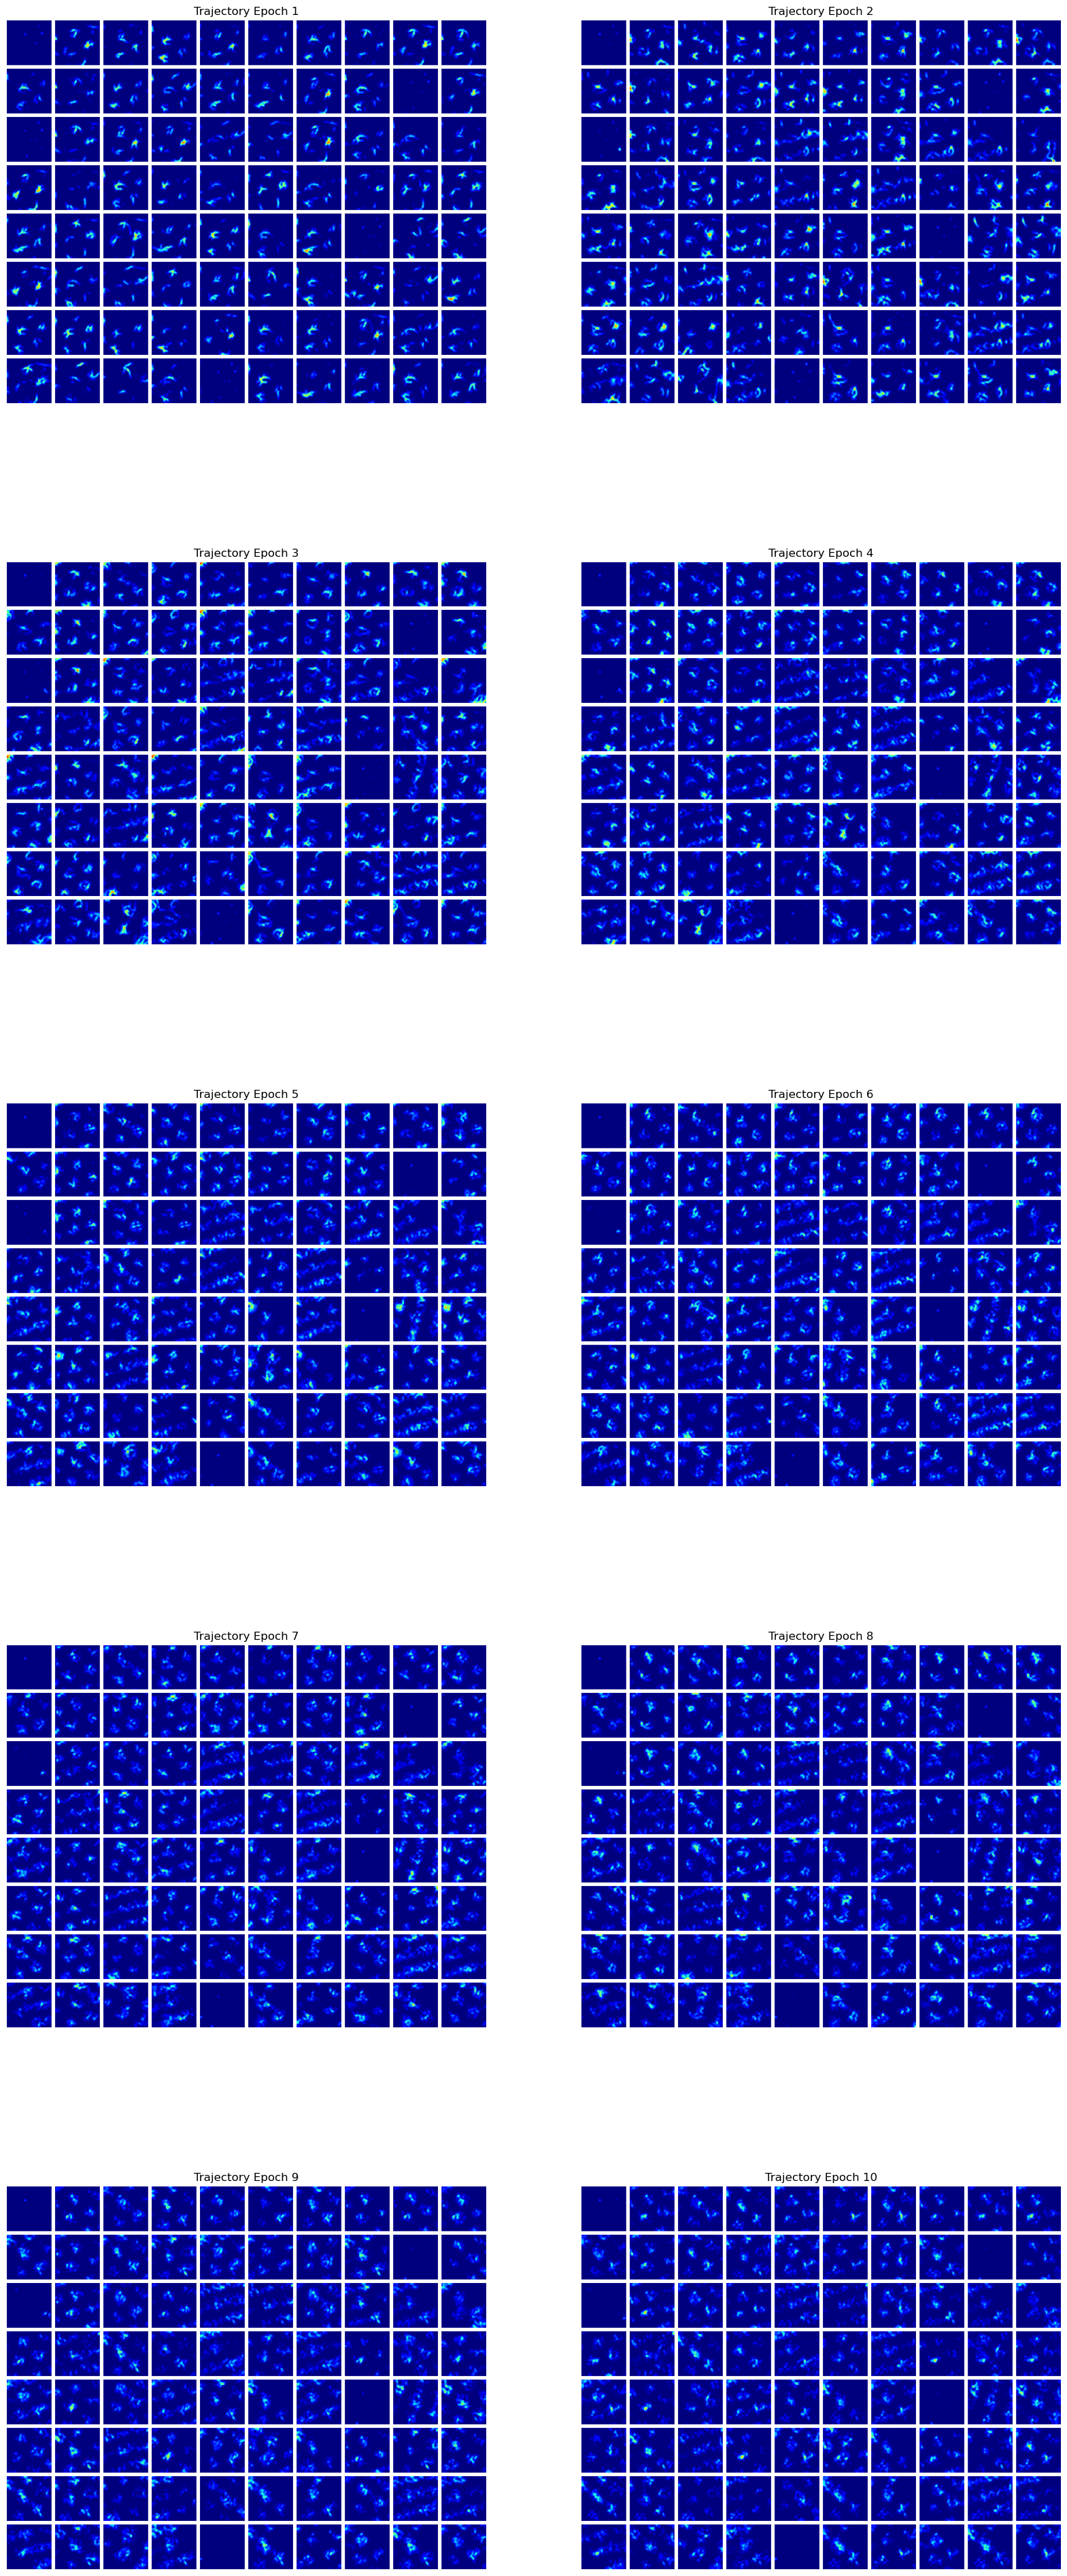

In [5]:
analysis_epochs = 10
res = 50
n_plots = 80
width = 10 # number of plots per row in the image

idxs = np.arange(options.Ng)

g = np.zeros([analysis_options.sequence_length, options.Ng])
pos = np.zeros([analysis_options.sequence_length, 2])

activations = np.zeros([options.Ng, res, res])
counts = np.zeros([res, res])
grid_activations = np.zeros([analysis_epochs, n_plots, res, res])

# Gets all relevant activations
inputs, pos_batch, _ = analysis_trajectory_generator.get_test_batch()
g_batch = net.grid(inputs).detach().cpu().numpy()

pos_batch = np.reshape(pos_batch.cpu(), [-1, 2])
g_batch = g_batch[:,:,idxs].reshape(-1, options.Ng)

g = g_batch
pos = pos_batch

x_batch = (pos_batch[:,0] + options.box_width/2) / (options.box_width) * res
y_batch = (pos_batch[:,1] + options.box_height/2) / (options.box_height) * res

for i in range(0, int(analysis_options.sequence_length / analysis_epochs)):
    x = x_batch[i]
    y = y_batch[i]
    if x >=0 and x < res and y >=0 and y < res:
        counts[int(x), int(y)] += 1
        activations[:, int(x), int(y)] += g_batch[i, :]

for x in range(res):
    for y in range(res):
        if counts[x, y] > 0:
            activations[:, x, y] /= counts[x, y]
            
g = g.reshape([-1, options.Ng])
pos = pos.reshape([-1, 2])

rate_map = activations.reshape(options.Ng, -1)

# Gets array of grid scores for all grid cells
grid_score = np.ones([options.Ng])

for i in range(grid_score.shape[0]):
    grid_score[i] = utils.calc_grid(activations[i])

# Stores indices of the grid cells with the highest grid scores
best_grid_cells = heapq.nlargest(n_plots, range(len(grid_score)), key=grid_score.__getitem__)

# Store the best grid cell activations from epoch 1
grid_activations[0] = activations[best_grid_cells]

# Make figure
fig, axs = plt.subplots(5, int(analysis_epochs / 5), figsize=(20, 50))
axs = axs.flatten()

# Plot the grid cells from epoch 1
axs[0].set_title("Trajectory Epoch 1")
rm_fig = utils.plot_ratemaps(activations, n_plots, smooth=True)
images = [utils.rgb(im) for im in activations[best_grid_cells]]
rm_fig = utils.concat_images_in_rows(images, n_plots//width, activations.shape[-1])
axs[0].imshow(rm_fig)
axs[0].axis('off')

# Get the indices of the cells with the max grid score then track those over time
for epoch in range(1, analysis_epochs):

    for i in range(int(analysis_options.sequence_length * (epoch)/ analysis_epochs), int(analysis_options.sequence_length * (epoch + 1) / analysis_epochs)):
        x = x_batch[i]
        y = y_batch[i]
        if x >=0 and x < res and y >=0 and y < res:
            counts[int(x), int(y)] += 1
            activations[:, int(x), int(y)] += g_batch[i, :]

    for x in range(res):
        for y in range(res):
            if counts[x, y] > 0:
                activations[:, x, y] /= counts[x, y]
                
    g = g.reshape([-1, options.Ng])
    pos = pos.reshape([-1, 2])

    rate_map = activations.reshape(options.Ng, -1)

    # Store best grid cell activations
    grid_activations[epoch] = activations[best_grid_cells]

    #axs[epoch].figure(figsize=(10, 30))
    axs[epoch].set_title(f"Trajectory Epoch {epoch + 1}")
    rm_fig = utils.plot_ratemaps(activations, n_plots, smooth=True)
    images = [utils.rgb(im) for im in activations[best_grid_cells]]
    rm_fig = utils.concat_images_in_rows(images, n_plots//width, activations.shape[-1])
    axs[epoch].imshow(rm_fig)
    axs[epoch].axis('off')

plt.show()

# Save ratemaps
# plt.savefig(f"images/{options.run_ID}/grid_cell.pdf")

## Translational Shift

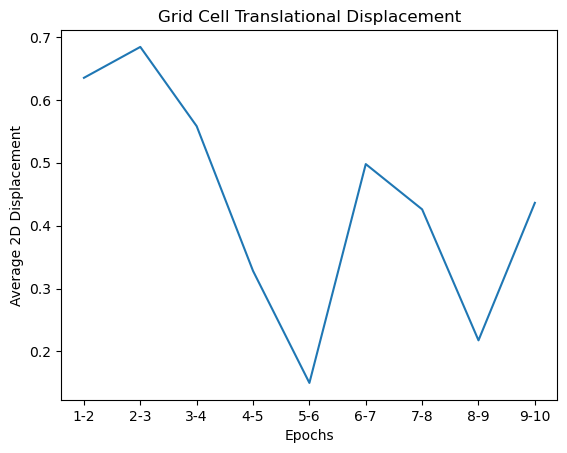

In [188]:
# Getting the displacements of grid cell shift over time through epochs

avg_displacements = np.zeros([analysis_epochs - 1])
displacements = np.zeros([analysis_epochs - 1, n_plots])
x = np.zeros([analysis_epochs - 1])
y = np.zeros([analysis_epochs - 1])

for epoch in range(avg_displacements.shape[0]):
    avg_displacements[epoch], displacements[epoch], x[epoch], y[epoch] = utils.translational_drift(grid_activations, n_plots, epoch, epoch + 1)

x_axis = ['1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10']
plt.plot(x_axis, avg_displacements)
plt.xlabel('Epochs')
plt.ylabel('Average 2D Displacement') # units are pixels
plt.title('Grid Cell Translational Displacement');

## Rotational Shift

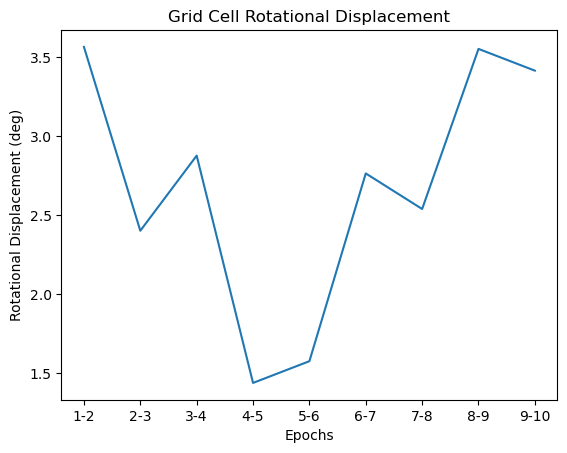

In [189]:
avg_rotations = np.zeros([analysis_epochs - 1])

for epoch in range(avg_rotations.shape[0]):
    avg_rotations[epoch] = utils.rotational_drift(grid_activations, n_plots, epoch, epoch + 1)

plt.plot(x_axis, avg_rotations)
plt.xlabel('Epochs')
plt.ylabel('Rotational Displacement (deg)')
plt.title('Grid Cell Rotational Displacement');

## Graphing

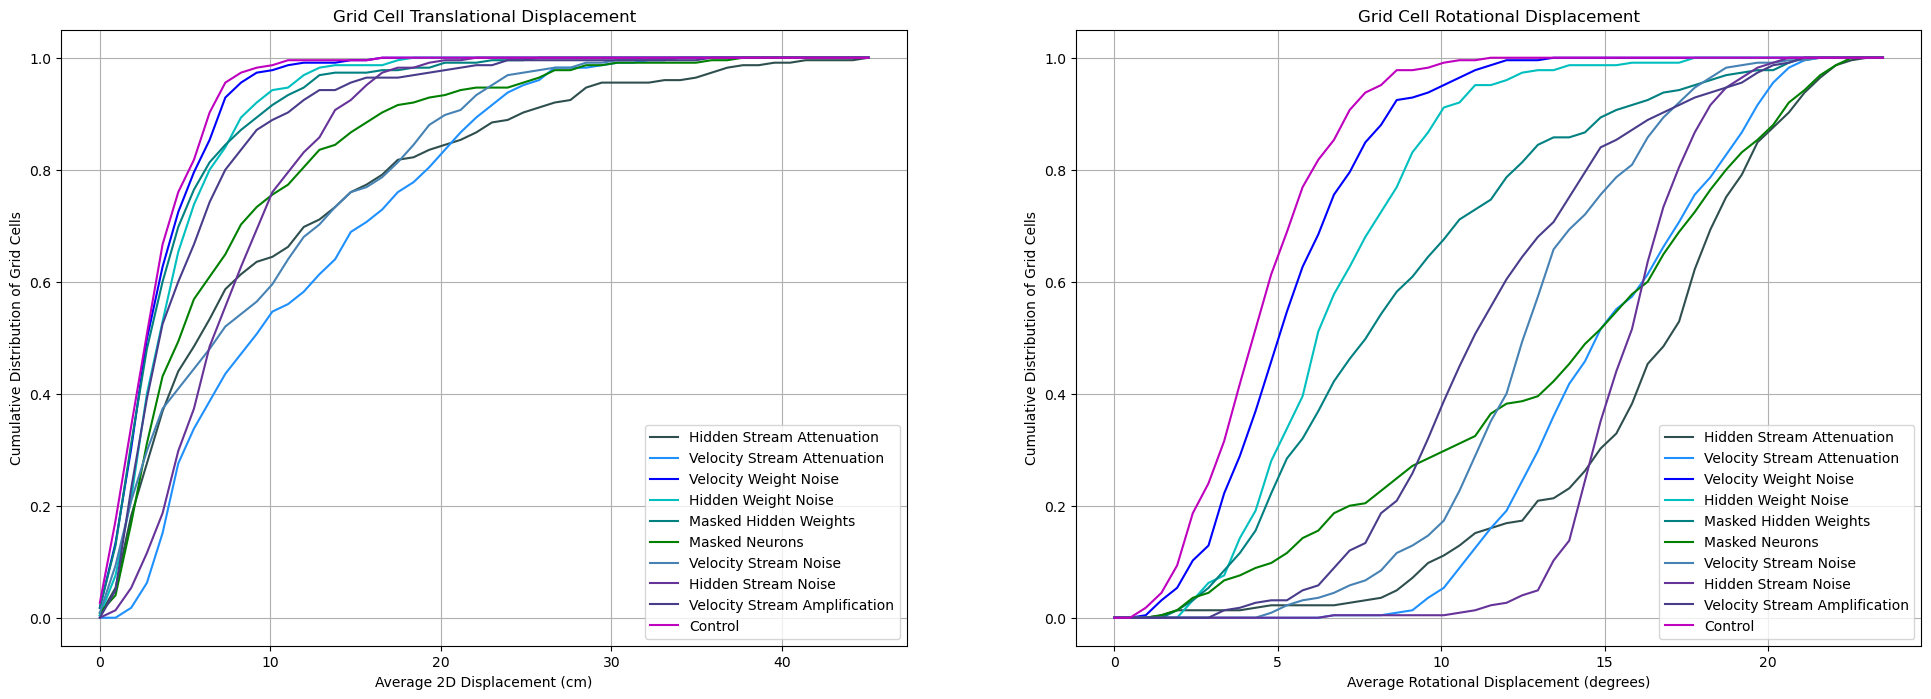

In [62]:
# Graphing Everything:


# Hidden layer scale
perturb_avg_displacements = np.load('/home/mira/Grid_Cell_RNN/data/0.5_hidscale_tlt.npy')
perturb_avg_rotations = np.load('/home/mira/Grid_Cell_RNN/data/0.5_hidscale_rot.npy')

# Velocity scale
velscale_displacements = np.load('/home/mira/Grid_Cell_RNN/data/0.5_velscale_tlt1.npy')
velscale_rotations = np.load('/home/mira/Grid_Cell_RNN/data/0.5_velscale_rot1.npy')

# Velocity weight noise
velweightnoise_displacements = np.load('/home/mira/Grid_Cell_RNN/data/0.1_velweightnoise_tlt.npy')
velweightnoise_rotations = np.load('/home/mira/Grid_Cell_RNN/data/0.1_velweightnoise_rot.npy')

# Hidden weight noise
hidweightnoise_displacements = np.load('/home/mira/Grid_Cell_RNN/data/0.001_hidweightnoise_tlt.npy')
hidweightnoise_rotations = np.load('/home/mira/Grid_Cell_RNN/data/0.001_hidweightnoise_rot.npy')

# Hidden weight mask
hidweightmask_displacements = np.load('/home/mira/Grid_Cell_RNN/data/0.001_hidweightmask_tlt.npy')
hidweightmask_rotations = np.load('/home/mira/Grid_Cell_RNN/data/0.001_hidweightmask_rot.npy')

# Neuron mask
neuronmask_displacements = np.load('/home/mira/Grid_Cell_RNN/data/0.003_neuronmask_tlt.npy')
neuronmask_rotations = np.load('/home/mira/Grid_Cell_RNN/data/0.003_neuronmask_rot.npy')

# Velocity stream noise
velnoise_displacements = np.load('/home/mira/Grid_Cell_RNN/data/0.3_velnoise_tlt.npy')
velnoise_rotations = np.load('/home/mira/Grid_Cell_RNN/data/0.3_velnoise_rot.npy')

# Hidden stream noise
hidnoise_displacements = np.load('/home/mira/Grid_Cell_RNN/data/0.1_hidnoise_tlt.npy')
hidnoise_rotations = np.load('/home/mira/Grid_Cell_RNN/data/0.1_hidnoise_rot.npy')

# Velocity stream scaling
velup_displacements = np.load('/home/mira/Grid_Cell_RNN/data/1.2_velscale_tlt.npy')
velup_rotations = np.load('/home/mira/Grid_Cell_RNN/data/1.2_velscale_rot.npy')

# Control
ctrl_avg_displacements = np.load('/home/mira/Grid_Cell_RNN/data/ctrl_tlt.npy')
ctrl_avg_rotations = np.load('/home/mira/Grid_Cell_RNN/data/ctrl_rot.npy')

# Plotting cumulative graph
plt.figure(figsize=(24, 8))

# Plotting translational
plt.subplot(121)
max_disp = np.ceil(np.max(perturb_avg_displacements))
num_bins = 50
bin_size = max_disp / num_bins
x = [bin_size * i for i in range(num_bins)]

cml_trans = [np.size(perturb_avg_displacements[perturb_avg_displacements < bin_size * i])/np.size(perturb_avg_displacements) for i in range(1, num_bins + 1)]
cml_velscalet = [np.size(velscale_displacements[velscale_displacements < bin_size * i])/np.size(velscale_displacements) for i in range(1, num_bins + 1)]
cml_velweightnoiset = [np.size(velweightnoise_displacements[velweightnoise_displacements < bin_size * i])/np.size(velweightnoise_displacements) for i in range(1, num_bins + 1)]
cml_hidweightnoiset = [np.size(hidweightnoise_displacements[hidweightnoise_displacements < bin_size * i])/np.size(hidweightnoise_displacements) for i in range(1, num_bins + 1)]
cml_hidweightmaskt = [np.size(hidweightmask_displacements[hidweightmask_displacements < bin_size * i])/np.size(hidweightmask_displacements) for i in range(1, num_bins + 1)]
cml_neuronmaskt = [np.size(neuronmask_displacements[neuronmask_displacements < bin_size * i])/np.size(neuronmask_displacements) for i in range(1, num_bins + 1)]
cml_velnoiset = [np.size(velnoise_displacements[velnoise_displacements < bin_size * i])/np.size(velnoise_displacements) for i in range(1, num_bins + 1)]
cml_hidnoiset = [np.size(hidnoise_displacements[hidnoise_displacements < bin_size * i])/np.size(hidnoise_displacements) for i in range(1, num_bins + 1)]
cml_velupt = [np.size(velup_displacements[velup_displacements < bin_size * i])/np.size(velup_displacements) for i in range(1, num_bins + 1)]
cml_trans_ctrl = [np.size(ctrl_avg_displacements[ctrl_avg_displacements < bin_size * i])/np.size(ctrl_avg_displacements) for i in range(1, num_bins + 1)]

plt.plot(x, cml_trans, color='darkslategray', label='Hidden Stream Attenuation')
plt.plot(x, cml_velscalet, color='dodgerblue', label='Velocity Stream Attenuation')
plt.plot(x, cml_velweightnoiset, color='b', label='Velocity Weight Noise')
plt.plot(x, cml_hidweightnoiset, color='c', label='Hidden Weight Noise')
plt.plot(x, cml_hidweightmaskt, color='teal', label='Masked Hidden Weights')
plt.plot(x, cml_neuronmaskt, color='g', label='Masked Neurons')
plt.plot(x, cml_velnoiset, color='steelblue', label='Velocity Stream Noise')
plt.plot(x, cml_hidnoiset, color='rebeccapurple', label='Hidden Stream Noise')
plt.plot(x, cml_velupt, color='darkslateblue', label='Velocity Stream Amplification')
plt.plot(x, cml_trans_ctrl, color='m', label='Control')
plt.xlabel('Average 2D Displacement (cm)')
plt.ylabel('Cumulative Distribution of Grid Cells')
plt.title('Grid Cell Translational Displacement')
plt.grid(True)
plt.legend(loc='lower right')

# Plotting rotational
plt.subplot(122)
max_disp = np.ceil(np.max(perturb_avg_rotations))
num_bins = 50
bin_size = max_disp / num_bins
x = [bin_size * i for i in range(num_bins)]

cml_rot = [np.size(perturb_avg_rotations[perturb_avg_rotations < bin_size * i])/np.size(perturb_avg_rotations) for i in range(1, num_bins + 1)]
cml_velscaler = [np.size(velscale_rotations[velscale_rotations < bin_size * i])/np.size(velscale_rotations) for i in range(1, num_bins + 1)]
cml_velweightnoiser = [np.size(velweightnoise_rotations[velweightnoise_rotations < bin_size * i])/np.size(velweightnoise_rotations) for i in range(1, num_bins + 1)]
cml_hidweightnoiser = [np.size(hidweightnoise_rotations[hidweightnoise_rotations < bin_size * i])/np.size(hidweightnoise_rotations) for i in range(1, num_bins + 1)]
cml_hidweightmaskr = [np.size(hidweightmask_rotations[hidweightmask_rotations < bin_size * i])/np.size(hidweightmask_rotations) for i in range(1, num_bins + 1)]
cml_neuronmaskr = [np.size(neuronmask_rotations[neuronmask_rotations < bin_size * i])/np.size(neuronmask_rotations) for i in range(1, num_bins + 1)]
cml_velnoiser = [np.size(velnoise_rotations[velnoise_rotations < bin_size * i])/np.size(velnoise_rotations) for i in range(1, num_bins + 1)]
cml_hidnoiser = [np.size(hidnoise_rotations[hidnoise_rotations < bin_size * i])/np.size(hidnoise_rotations) for i in range(1, num_bins + 1)]
cml_velupr = [np.size(velup_rotations[velup_rotations < bin_size * i])/np.size(velup_rotations) for i in range(1, num_bins + 1)]
cml_rot_ctrl = [np.size(ctrl_avg_rotations[ctrl_avg_rotations < bin_size * i])/np.size(ctrl_avg_rotations) for i in range(1, num_bins + 1)]

plt.plot(x, cml_rot, color='darkslategray', label='Hidden Stream Attenuation')
plt.plot(x, cml_velscaler, color='dodgerblue', label='Velocity Stream Attenuation')
plt.plot(x, cml_velweightnoiser, color='b', label='Velocity Weight Noise')
plt.plot(x, cml_hidweightnoiser, color='c', label='Hidden Weight Noise')
plt.plot(x, cml_hidweightmaskr, color='teal', label='Masked Hidden Weights')
plt.plot(x, cml_neuronmaskr, color='g', label='Masked Neurons')
plt.plot(x, cml_velnoiser, color='steelblue', label='Velocity Stream Noise')
plt.plot(x, cml_hidnoiser, color='rebeccapurple', label='Hidden Stream Noise')
plt.plot(x, cml_velupr, color='darkslateblue', label='Velocity Stream Amplification')
plt.plot(x, cml_rot_ctrl, color='m', label='Control')
plt.xlabel('Average Rotational Displacement (degrees)')
plt.ylabel('Cumulative Distribution of Grid Cells')
plt.title('Grid Cell Rotational Displacement')
plt.grid(True)
plt.legend(loc='lower right')

#plt.savefig('/home/mira/Grid_Cell_RNN/images/cml_0.5_velweightmask.png')
plt.show()


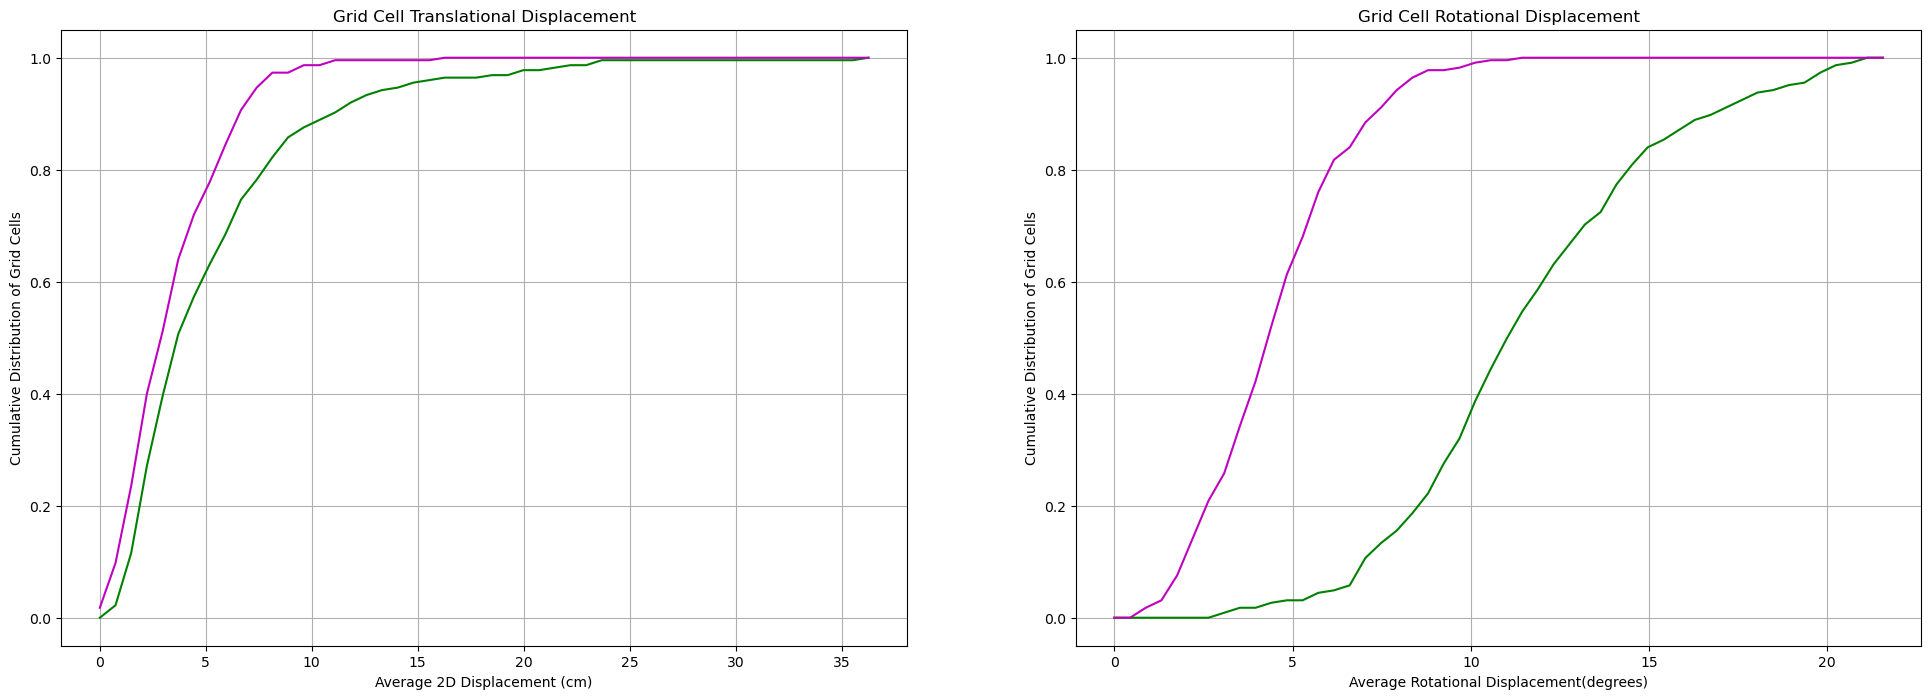

In [61]:
# Graphing:

perturb_avg_displacements = np.load('/home/mira/Grid_Cell_RNN/data/1.2_velscale_tlt.npy')
perturb_avg_rotations = np.load('/home/mira/Grid_Cell_RNN/data/1.2_velscale_rot.npy')

ctrl_avg_displacements = np.load('/home/mira/Grid_Cell_RNN/data/ctrl_tlt.npy')
ctrl_avg_rotations = np.load('/home/mira/Grid_Cell_RNN/data/ctrl_rot.npy')

# Plotting cumulative graph
plt.figure(figsize=(24, 8))

# Plotting translational
plt.subplot(121)
max_disp = np.ceil(np.max(perturb_avg_displacements))
num_bins = 50
bin_size = max_disp / num_bins
x = [bin_size * i for i in range(num_bins)]

cml_trans = [np.size(perturb_avg_displacements[perturb_avg_displacements < bin_size * i])/np.size(perturb_avg_displacements) for i in range(1, num_bins + 1)]
cml_trans_ctrl = [np.size(ctrl_avg_displacements[ctrl_avg_displacements < bin_size * i])/np.size(ctrl_avg_displacements) for i in range(1, num_bins + 1)]
plt.plot(x, cml_trans, color='g')
plt.plot(x, cml_trans_ctrl, color='m')
plt.xlabel('Average 2D Displacement (cm)')
plt.ylabel('Cumulative Distribution of Grid Cells')
plt.title('Grid Cell Translational Displacement')
plt.grid(True)

# Plotting rotational
plt.subplot(122)
max_disp = np.ceil(np.max(perturb_avg_rotations))
num_bins = 50
bin_size = max_disp / num_bins
x = [bin_size * i for i in range(num_bins)]

cml_rot = [np.size(perturb_avg_rotations[perturb_avg_rotations < bin_size * i])/np.size(perturb_avg_rotations) for i in range(1, num_bins + 1)]
cml_rot_ctrl = [np.size(ctrl_avg_rotations[ctrl_avg_rotations < bin_size * i])/np.size(ctrl_avg_rotations) for i in range(1, num_bins + 1)]
plt.plot(x, cml_rot, color='g')
plt.plot(x, cml_rot_ctrl, color='m')
plt.xlabel('Average Rotational Displacement(degrees)')
plt.ylabel('Cumulative Distribution of Grid Cells')
plt.title('Grid Cell Rotational Displacement')
plt.grid(True)

#plt.savefig('/home/mira/Grid_Cell_RNN/images/cml_0.5_velweightmask.png')
plt.show()


## Connectivity Matrix

In [5]:
from scipy.sparse.csgraph import reverse_cuthill_mckee
from scipy.sparse import csr_matrix

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Cuda devices: {list(range(torch.cuda.device_count()))}, {
        list(map(torch.cuda.get_device_name, list(range(torch.cuda.device_count()))))}")
print(f"Using {device}, {torch.cuda.get_device_name(device)} device")

torch.cuda.empty_cache() # PyTorch empty chaces

Cuda devices: [0, 1], ['NVIDIA GeForce RTX 3090', 'NVIDIA GeForce RTX 3090']
Using cuda:0, NVIDIA GeForce RTX 3090 device


tensor(-0.0889, device='cuda:0')
tensor(0.1951, device='cuda:0')


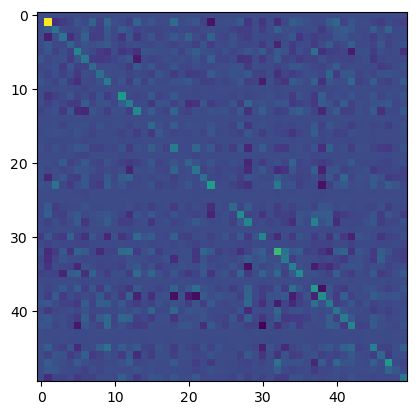

In [69]:
# Load weights
# W = torch.load('weight_tensor.pt', weights_only=True)
W = net.hid_stream.weight
W.requires_grad = False

print(torch.min(W))
print(torch.max(W))
plt.imshow(W.cpu()[0:50,0:50]);

In [70]:
# Use reverse cuthill mckee
graph = csr_matrix(np.where( W.cpu().numpy() > 0.0, 1, 0)) # threshold for positive weights
graph2= csr_matrix(np.where(torch.abs(W).cpu().numpy() > 0.02, 1, 0)) # threshold for greater positive weights
graph3 = csr_matrix(np.where(W.cpu().numpy() < 0.0, 1, 0)) # threshold for negative weights

# Find permuation using RCM (reverse Cuthill-McKee)
perm = reverse_cuthill_mckee(graph)
perm2 = reverse_cuthill_mckee(graph2)
perm3 = reverse_cuthill_mckee(graph3)

# create reordered marix
weight_perm = W.cpu().numpy()[perm][:, perm]
weight_perm2 = W.cpu().numpy()[perm2][:, perm2]
weight_perm3 = W.cpu().numpy()[perm3][:, perm3]


weight_perm = weight_perm * np.where(weight_perm > 0.0, 1, 0)
weight_perm2 = weight_perm2 * np.where(np.abs(weight_perm2) > 0.02, 1, 0)
weight_perm3 = weight_perm3 * np.where(weight_perm3 < 0.0, 1, 0)

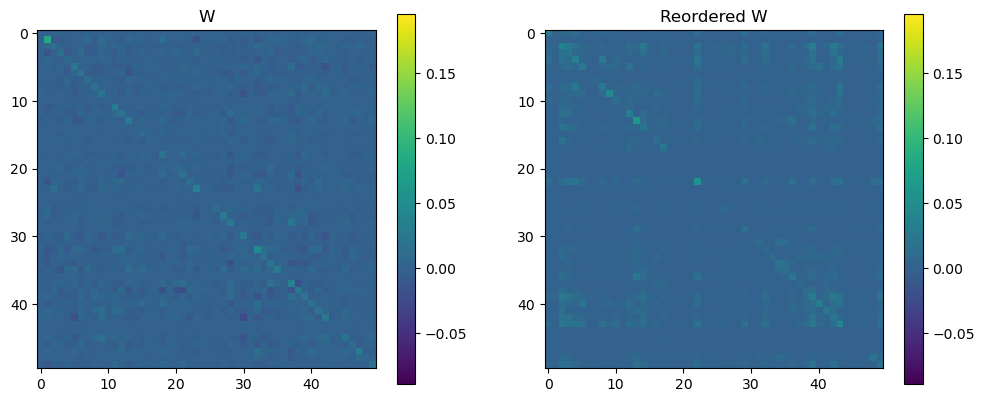

In [71]:
# Create a figure and axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot on the first axis
cax1 = ax1.imshow(W.cpu()[0:50, 0:50], cmap='viridis')
ax1.set_title('W')
# Set color limits for the first subplot
cax1.set_clim(float(torch.min(W).item()), float(torch.max(W).item()))
fig.colorbar(cax1, ax=ax1, shrink=0.8)

# Plot on the second axis
cax2 = ax2.imshow(weight_perm[0:50, 0:50], cmap='viridis')
ax2.set_title('Reordered W')
# Set color limits for the second subplot
cax2.set_clim(float(torch.min(W).item()), float(torch.max(W).item()))
fig.colorbar(cax2, ax=ax2, shrink=0.8)

# Show the plots
plt.show()

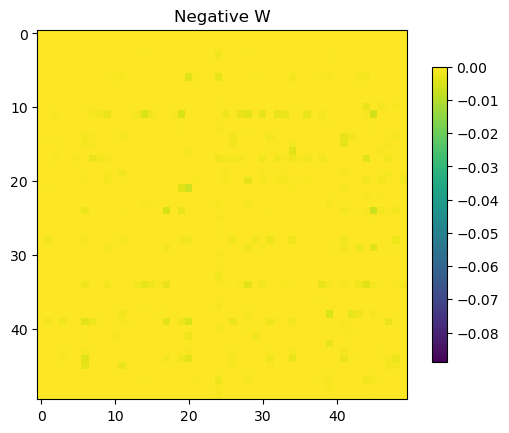

In [72]:
# Plot inhibitory connectivities

plt.imshow(weight_perm3[0:50, 0:50], cmap='viridis',vmin=float(torch.min(W).item()),vmax=float(torch.max(W).item()))
plt.title('Negative W')
# Set color limits for the second subplot
plt.clim(float(torch.min(W).item()), 0.0)#float(torch.max(W).item())
plt.colorbar(shrink=0.8)

(-0.001, 0.001)

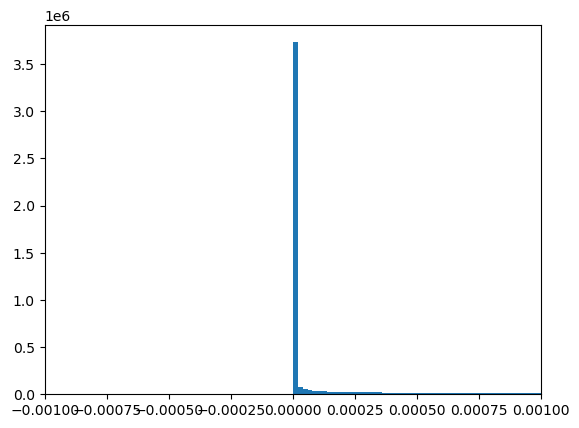

In [73]:
# Looking at weights histogram
plt.hist(weight_perm.flatten(), bins=1000, range=(-0.01,0.01));
plt.xlim(-0.001,0.001)

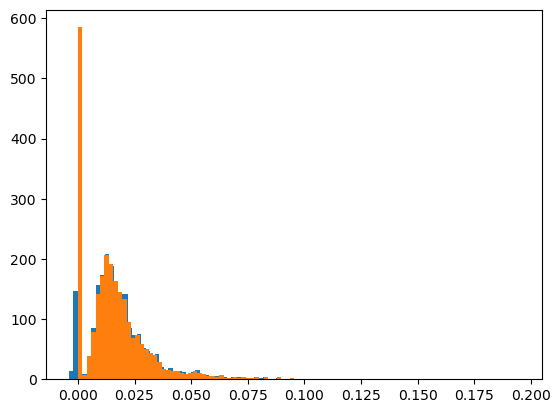

In [74]:
# Looking at diagonals

diag = torch.diagonal(W, 0)
diag_reordered = np.diag(weight_perm)

plt.hist(diag.cpu(), bins=100);

plt.hist(diag_reordered, bins=100);